## abstract class

In [1]:
from abc import ABC, abstractmethod

class OptimizationProblem(ABC):
    """
    Abstract base class for optimization problems to be solved with simulated annealing.
    """
    
    @abstractmethod
    def cost(self, solution):
        """
        Calculate the cost (objective function value) for a given solution.
        Lower cost is better.
        
        Args:
            solution: A candidate solution
            
        Returns:
            float: The cost of the solution
        """
        pass
    
    @abstractmethod
    def random_neighbor(self, solution):
        """
        Generate a random neighbor of the current solution.
        
        Args:
            solution: The current solution
            
        Returns:
            A neighboring solution
        """
        pass

In [2]:
import math, random

def simulated_annealing(
    problem: OptimizationProblem, initial_solution, T0, alpha, max_iter
):
    current = initial_solution
    best = current
    T = T0

    for i in range(max_iter):
        neighbor = problem.random_neighbor(current)
        delta = problem.cost(neighbor) - problem.cost(current)

        if delta < 0 or random.random() < math.exp(-delta / T):
            current = neighbor
            if problem.cost(current) < problem.cost(best):
                best = current

        T *= alpha  # cooling
        if T < 1e-6:
            break

    return best


## Travelling Salesman Problem (TSP) Example

In [3]:
# Example: Traveling Salesman Problem (TSP)
class TSPProblem(OptimizationProblem):
    """
    Example implementation: Traveling Salesman Problem
    """
    
    def __init__(self, cities, distances):
        """
        Args:
            cities: List of city names/indices
            distances: 2D array/dict of distances between cities
        """
        self.cities = cities
        self.distances = distances
    
    def cost(self, solution):
        """Calculate total tour distance"""
        total = 0
        for i in range(len(solution)):
            city_a = solution[i]
            city_b = solution[(i + 1) % len(solution)]
            total += self.distances[city_a][city_b]
        return total
    
    def random_neighbor(self, solution):
        """Generate neighbor by swapping two random cities"""
        neighbor = solution.copy()
        i, j = random.sample(range(len(neighbor)), 2)
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        return neighbor

In [4]:

cities = [0, 1, 2, 3, 4]
distances = [
    [0, 10, 15, 20, 25],
    [10, 0, 35, 25, 30],
    [15, 35, 0, 30, 20],
    [20, 25, 30, 0, 15],
    [25, 30, 20, 15, 0]
]

# Create problem instance
tsp = TSPProblem(cities, distances)

# Initial solution (random tour)
initial = cities.copy()
random.shuffle(initial)

# Run simulated annealing
best_solution = simulated_annealing(
    problem=tsp,
    initial_solution=initial,
    T0=1000,
    alpha=0.95,
    max_iter=10000
)

print(f"Best tour: {best_solution}")
print(f"Best cost: {tsp.cost(best_solution)}")

Best tour: [3, 1, 0, 2, 4]
Best cost: 85


## 0/1 Knapsack Problem

In [5]:
class KnapsackProblem(OptimizationProblem):
    """
    0/1 Knapsack Problem implementation for Simulated Annealing.
    """

    def __init__(self, values, weights, capacity):
        """
        Args:
            values: List of item values
            weights: List of item weights
            capacity: Maximum allowed weight
        """
        self.values = values
        self.weights = weights
        self.capacity = capacity

    def cost(self, solution):
        """
        Compute the *negative total value* if constraints are satisfied,
        otherwise apply a penalty for overweight solutions.
        Lower is better.
        """
        total_value = sum(v for v, s in zip(self.values, solution) if s)
        total_weight = sum(w for w, s in zip(self.weights, solution) if s)

        if total_weight <= self.capacity:
            return -total_value  # negative since we minimize cost
        else:
            # impose a penalty for exceeding capacity
            penalty = (total_weight - self.capacity) * 100
            return penalty

    def random_neighbor(self, solution):
        """
        Flip a random bit (add or remove an item).
        """
        neighbor = solution.copy()
        i = random.randrange(len(solution))
        neighbor[i] = 1 - neighbor[i]  # toggle inclusion
        return neighbor


In [6]:
values = [20, 5, 10, 40, 15, 25]
weights = [1, 2, 3, 8, 7, 4]
capacity = 10

problem = KnapsackProblem(values, weights, capacity)

initial_solution = [0] * len(values)
best_solution = simulated_annealing(problem, initial_solution, T0=10, alpha=0.95, max_iter=1000)

print("Best solution:", best_solution)
print("Best value:", -problem.cost(best_solution))

Best solution: [1, 0, 0, 1, 0, 0]
Best value: 60


## Flow Shop Scheduling Problem

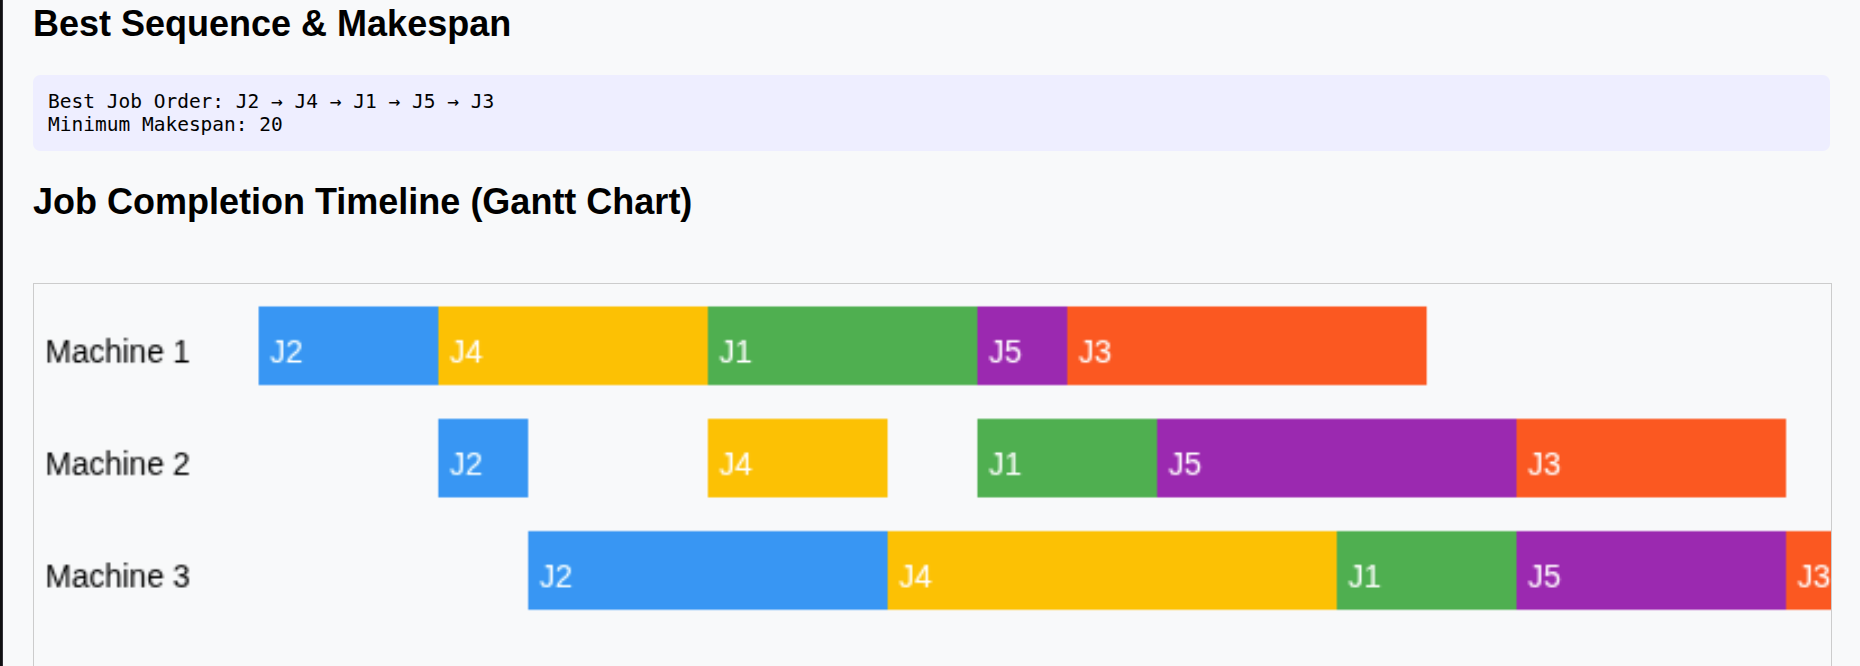

In [7]:
class FlowShopSchedulingProblem(OptimizationProblem):
    """
    Flow Shop Scheduling Problem (multiple machines, same order of jobs).
    Objective: minimize total makespan.
    """

    def __init__(self, processing_times):
        """
        Args:
            processing_times: 2D list, where
                processing_times[i][j] = processing time of job i on machine j.
        """
        self.processing_times = processing_times
        self.n_jobs = len(processing_times)
        self.n_machines = len(processing_times[0])

    def cost(self, job_sequence):
        """
        Compute the makespan for a given sequence of jobs.
        """
        n, m = self.n_jobs, self.n_machines
        times = [[0] * (m + 1) for _ in range(n + 1)]

        # Dynamic computation of completion times
        for i, job in enumerate(job_sequence, start=1):
            for machine in range(1, m + 1):
                times[i][machine] = (
                    max(times[i - 1][machine], times[i][machine - 1])
                    + self.processing_times[job][machine - 1]
                )
        return times[n][m]  # makespan (completion time of last job on last machine)

    def random_neighbor(self, solution):
        """
        Swap two jobs randomly to get a neighbor (keeps permutation constraint).
        """
        neighbor = solution.copy()
        i, j = random.sample(range(len(solution)), 2)
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        return neighbor


In [8]:
# Example: 5 jobs, 3 machines
# Each row = a job, each column = machine processing time

# e.g. for job 1 : [3, 2, 2] means
# machine 1 takes 3 units, then machine 2 takes 2 units, then machine 3 takes 2 units
# machine 2 cannot start until machine 1 is done with job 1, etc.
processing_times = [
    [3, 2, 2], # job 0
    [2, 1, 4], # job 1
    [4, 3, 3], # job 2
    [3, 2, 5], # job 3
    [1, 4, 3], # job 4
]

# Random initial sequence of jobs
initial_sequence = random.sample(range(len(processing_times)), len(processing_times))
print("Initial job order:", initial_sequence)

problem = FlowShopSchedulingProblem(processing_times)

best_sequence = simulated_annealing(problem, initial_sequence, T0=10, alpha=0.95, max_iter=2000)

print("Best job order:", best_sequence)
print("Minimum makespan:", problem.cost(best_sequence))

Initial job order: [4, 1, 3, 2, 0]
Best job order: [1, 3, 0, 4, 2]
Minimum makespan: 20


## Graph Coloring Problem


In [9]:
class GraphColoringProblem(OptimizationProblem):
    """
    Graph Coloring Problem:
    Minimize the number of adjacent vertices that share the same color.
    """

    def __init__(self, adjacency_list, num_colors):
        """
        Args:
            adjacency_list (dict): {node: [neighbors]}
            num_colors (int): number of available colors
        """
        self.adjacency_list = adjacency_list
        self.nodes = list(adjacency_list.keys())
        self.num_colors = num_colors

    def cost(self, solution):
        """
        Count number of conflicting edges (same color on both ends).
        """
        conflicts = 0
        for node in self.nodes:
            for neighbor in self.adjacency_list[node]: # for every pair of neighbors
                if solution[node] == solution[neighbor]:
                    conflicts += 1
        return conflicts // 2  # divide by 2, since each edge counted twice

    def random_neighbor(self, solution):
        """
        Change color of a random node to a random new color.
        """
        neighbor = solution.copy()
        node = random.choice(self.nodes)
        current_color = neighbor[node]
        available_colors = list(range(self.num_colors))
        available_colors.remove(current_color)
        neighbor[node] = random.choice(available_colors)
        return neighbor


In [10]:
# Define a simple graph (adjacency list)
graph = {
    0: [1, 2, 3],
    1: [0, 2],
    2: [0, 1, 3],
    3: [0, 2]
}

num_colors = 3

# Random initial coloring
initial_solution = {node: random.randint(0, num_colors - 1) for node in graph}

problem = GraphColoringProblem(graph, num_colors)
best_solution = simulated_annealing(problem, initial_solution, T0=10, alpha=0.95, max_iter=2000)

print("Initial Coloring:", initial_solution)
print("Final Coloring:", best_solution)
print("Conflicts:", problem.cost(best_solution))

Initial Coloring: {0: 1, 1: 0, 2: 0, 3: 1}
Final Coloring: {0: 2, 1: 0, 2: 1, 3: 0}
Conflicts: 0


In [11]:
def generate_random_graph(n_nodes=30, edge_probability=0.2):
    """
    Generate an undirected random graph using simple probability model.
    """
    adjacency_list = {i: [] for i in range(n_nodes)}
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            if random.random() < edge_probability:
                adjacency_list[i].append(j)
                adjacency_list[j].append(i)
    return adjacency_list


In [12]:
# random.seed(42)  # reproducibility

# Create large random graph
n_nodes = 100
num_colors = 5
edge_probability = 0.2  # denser graphs are harder
graph = generate_random_graph(n_nodes, edge_probability)

# Random initial coloring
initial_solution = {node: random.randint(0, num_colors - 1) for node in graph}

# Define problem
problem = GraphColoringProblem(graph, num_colors)

# Solve with simulated annealing
best_solution = simulated_annealing(problem, initial_solution, T0=15, alpha=0.98, max_iter=500000)

# Results
print("Graph has", n_nodes, "nodes and", 
        sum(len(neighs) for neighs in graph.values()) // 2, "edges.")
print("Using", num_colors, "available colors.\n")

print("Initial Conflicts:", problem.cost(initial_solution))
print("Final Conflicts:", problem.cost(best_solution))
print("\nBest Coloring (node: color):")
for node in sorted(best_solution.keys()):
    print(f"  {node:2d}: Color {best_solution[node]}")

Graph has 100 nodes and 1005 edges.
Using 5 available colors.

Initial Conflicts: 195
Final Conflicts: 74

Best Coloring (node: color):
   0: Color 3
   1: Color 4
   2: Color 2
   3: Color 3
   4: Color 1
   5: Color 3
   6: Color 0
   7: Color 1
   8: Color 4
   9: Color 3
  10: Color 2
  11: Color 2
  12: Color 0
  13: Color 3
  14: Color 2
  15: Color 4
  16: Color 3
  17: Color 1
  18: Color 4
  19: Color 1
  20: Color 3
  21: Color 4
  22: Color 0
  23: Color 2
  24: Color 3
  25: Color 3
  26: Color 0
  27: Color 0
  28: Color 0
  29: Color 1
  30: Color 1
  31: Color 4
  32: Color 0
  33: Color 3
  34: Color 4
  35: Color 3
  36: Color 3
  37: Color 1
  38: Color 3
  39: Color 0
  40: Color 0
  41: Color 4
  42: Color 1
  43: Color 2
  44: Color 3
  45: Color 0
  46: Color 2
  47: Color 1
  48: Color 1
  49: Color 2
  50: Color 4
  51: Color 2
  52: Color 2
  53: Color 4
  54: Color 2
  55: Color 2
  56: Color 2
  57: Color 1
  58: Color 1
  59: Color 1
  60: Color 3
  61: Colo

## Bin Packing Problem

Given a set of items with different sizes, pack them into the minimum number of bins of fixed capacity.

In [13]:
class BinPackingProblem(OptimizationProblem):
    """
    Bin Packing Problem:
    Minimize number of bins used without exceeding bin capacity.
    """

    def __init__(self, items, bin_capacity):
        self.items = items
        self.capacity = bin_capacity

    def cost(self, solution):
        """
        Objective: minimize the number of bins used.
        Penalize overloaded bins.
        """
        bins_used = len(solution)
        penalty = 0
        for bin_items in solution:
            total_weight = sum(bin_items)
            if total_weight > self.capacity:
                penalty += total_weight - self.capacity
        return bins_used + penalty  # fewer bins and no overflow preferred

    def random_neighbor(self, solution):
        """
        Move an item from one bin to another (or to a new bin).
        """
        neighbor = [bin_[:] for bin_ in solution]  # deep copy
        if not neighbor:
            return neighbor

        # Choose random non-empty source bin and item
        source_bin = random.choice([b for b in neighbor if b])
        item = random.choice(source_bin)
        source_bin.remove(item)

        # Remove empty bin if necessary
        if not source_bin:
            neighbor.remove(source_bin)

        # Choose destination bin (maybe new one)
        if random.random() < 0.2 or not neighbor:  # sometimes add new bin
            neighbor.append([item])
        else:
            dest_bin = random.choice(neighbor)
            dest_bin.append(item)

        return neighbor


In [14]:
# random.seed(42)

# Define item weights and bin capacity
items = [5, 9, 7, 3, 2, 8, 4, 6, 2, 5, 9, 1, 3, 2, 4, 6, 7, 8]
bin_capacity = 20

# Random initial packing: one bin per item
initial_solution = [[item] for item in items]

# Define problem
problem = BinPackingProblem(items, bin_capacity)

# Run simulated annealing
best_solution = simulated_annealing(problem, initial_solution, T0=10, alpha=0.98, max_iter=5000)

# Results
print("Initial bins used:", len(initial_solution))
print("Final bins used:", len(best_solution))
print("\nFinal bin configuration:")
for i, b in enumerate(best_solution, start=1):
    print(f" Bin {i}: {b}  (Weight={sum(b)})")

Initial bins used: 18
Final bins used: 5

Final bin configuration:
 Bin 1: [8, 7, 2, 1]  (Weight=18)
 Bin 2: [3, 9, 8]  (Weight=20)
 Bin 3: [3, 7, 2, 2, 6]  (Weight=20)
 Bin 4: [6, 4, 9]  (Weight=19)
 Bin 5: [4, 5, 5]  (Weight=14)


In [15]:
best_solution


[[8, 7, 2, 1], [3, 9, 8], [3, 7, 2, 2, 6], [6, 4, 9], [4, 5, 5]]

## Set Covering / Partitioning Problem

You are given:
- A universe of elements U = {1, 2, ..., n}
- A collection of subsets S = {S_1, S_2, ..., S_m} where each with an associated cost c_i

The Goal:
- Select a subset of these sets so that every element in U is covered at least once (Set Covering) or exactly once (Set Partitioning) while minimizing the total cost.

In [16]:
class SetCoveringProblem(OptimizationProblem):
    """
    Minimize total subset cost while covering all elements.
    """

    def __init__(self, universe, subsets, costs):
        self.universe = set(universe)
        self.subsets = [set(s) for s in subsets]
        self.costs = costs
        self.num_sets = len(subsets)

    def cost(self, solution):
        """
        Cost = sum of selected set costs + penalty for uncovered elements
        """
        # total cost equals to the sum of costs of selected subsets
        total_cost = sum(
            self.costs[i] for i in range(self.num_sets) if solution[i] == 1
        )

        # Check coverage
        covered = set()
        for i in range(self.num_sets):
            if solution[i] == 1:
                covered |= self.subsets[i]

        uncovered = len(self.universe - covered)
        penalty = 100 * uncovered  # heavy penalty for any uncovered element
        return total_cost + penalty

    def random_neighbor(self, solution):
        """
        Toggle (flip) a random subset — add or remove it.
        """
        neighbor = solution[:]  # shallow copy
        i = random.randrange(self.num_sets)  # select a random set with index i
        neighbor[i] = 1 - neighbor[i]  # flip bit: 1→0, 0→1
        return neighbor


In [20]:
random.seed(42)

# Define example
universe = {1, 2, 3, 4, 5, 6}
subsets = [
    {1, 2, 3},
    {2, 4},
    {3, 4, 5},
    {5, 6},
    {1, 4, 6}
]
costs = [5, 4, 6, 3, 7]

# Initial solution: randomly include sets
initial_solution = [random.choice([0, 1]) for _ in subsets]

# Problem
problem = SetCoveringProblem(universe, subsets, costs)

# Run simulated annealing
best_solution = simulated_annealing(problem, initial_solution, T0=10, alpha=0.98, max_iter=10000)

# Results
print("Initial solution:", initial_solution)
print("Best solution found:", best_solution)
print("Minimum Cost:", problem.cost(best_solution))

# Print coverage details
selected_sets = [i+1 for i in range(len(best_solution)) if best_solution[i] == 1]
print("Selected sets:", selected_sets)
covered = set.union(*(subsets[i] for i in range(len(best_solution)) if best_solution[i] == 1))
print("Covered elements:", covered)

Initial solution: [0, 0, 1, 0, 0]
Best solution found: [1, 1, 0, 1, 0]
Minimum Cost: 12
Selected sets: [1, 2, 4]
Covered elements: {1, 2, 3, 4, 5, 6}


In [25]:
class SetPartitioningProblem(OptimizationProblem):
    """
    Minimize total subset cost while covering all elements exactly once.
    """

    def __init__(self, universe, subsets, costs):
        self.universe = set(universe)
        self.subsets = [set(s) for s in subsets]
        self.costs = costs
        self.num_sets = len(subsets)

    def cost(self, solution):
        """
        Cost = total selected set cost
            + penalty for uncovered elements
            + penalty for overlapping (duplicate) coverage
        """
        total_cost = sum(self.costs[i] for i in range(self.num_sets) if solution[i] == 1)

        # Compute coverage count per element
        coverage_count = {elem: 0 for elem in self.universe}
        for i in range(self.num_sets):
            if solution[i] == 1:
                for elem in self.subsets[i]:
                    coverage_count[elem] = coverage_count.get(elem, 0) + 1

        # Uncovered elements (count == 0)
        uncovered = sum(1 for elem, count in coverage_count.items() if count == 0)
        uncovered_penalty = 100 * uncovered  # large

        # Overlaps (count > 1)
        overlaps = sum(count - 1 for count in coverage_count.values() if count > 1)
        overlap_penalty = 50 * overlaps  # moderate penalty for duplicate covers

        return total_cost + uncovered_penalty + overlap_penalty

    def random_neighbor(self, solution):
        """
        Toggle (flip) a random subset — add or remove it.
        """
        neighbor = solution[:]  # shallow copy
        i = random.randrange(self.num_sets)  # select a random set with index i
        neighbor[i] = 1 - neighbor[i]  # flip bit: 1→0, 0→1
        return neighbor


In [42]:
# Define example
universe = {1, 2, 3, 4, 5, 6}
subsets = [{1, 2, 3}, 
           {2, 4}, 
           {3, 4, 5}, 
           {4, 5, 6}, 
           {1, 4, 6}]
costs = [5, 4, 6, 3, 7]

# Initial solution: randomly include sets
initial_solution = [random.choice([0, 1]) for _ in subsets]

# Problem
problem = SetPartitioningProblem(universe, subsets, costs)

# Run simulated annealing
best_solution = simulated_annealing(
    problem, initial_solution, T0=10, alpha=0.98, max_iter=10000
)

# Results
print("Initial solution:", initial_solution)
print("Best solution found:", best_solution)
print("Minimum Cost:", problem.cost(best_solution))

# Print coverage details
selected_sets = [i + 1 for i in range(len(best_solution)) if best_solution[i] == 1]
print("Selected sets:", selected_sets)
covered = set.union(
    *(subsets[i] for i in range(len(best_solution)) if best_solution[i] == 1)
)
print("Covered elements:", covered)


Initial solution: [0, 1, 0, 1, 0]
Best solution found: [1, 0, 0, 1, 0]
Minimum Cost: 8
Selected sets: [1, 4]
Covered elements: {1, 2, 3, 4, 5, 6}


## Quadratic Assignment Problem

one of the most famous NP-hard combinatorial optimization problems

- Assign n facilities to n locations such that the total cost of interaction between facilities is minimized.

Formally:

$$
\text{Minimize } \sum_{i=1}^{n} \sum_{j=1}^{n} f_{ij} \cdot d_{p(i)p(j)}
$$

where:
- $ f_{ij} $ is the flow between facility i and facility j
- $ d_{p(i)p(j)} $ is the distance between location p(i) and location p(j)
- $p(i)$ is the location assigned to facility i

Applications:

Each pair of facilities has a flow value between them (e.g., communication, transportation) 

Each pair of locations has a distance separating them (e.g., physical distance, time delay)

If a facility with high traffic is placed far away from its major partners, the overall cost increases significantly.

Hence, the objective is to assign facilities to locations so that high-flow pairs are placed close together, minimizing the total flow x distnace.

In [43]:
class QuadraticAssignmentProblem(OptimizationProblem):
    """
    Facilities → Locations assignment problem
    """

    def __init__(self, flow_matrix, distance_matrix):
        assert len(flow_matrix) == len(distance_matrix)
        self.n = len(flow_matrix)
        self.flow = flow_matrix
        self.distance = distance_matrix

    def cost(self, solution):
        """Total cost given a permutation of assignments"""
        total = 0
        n = self.n
        for i in range(n):
            for j in range(n):
                total += self.flow[i][j] * self.distance[solution[i]][solution[j]]
        return total

    def random_neighbor(self, solution):
        """Swap two assignments (i.e., swap two facilities)"""
        i, j = random.sample(range(self.n), 2)
        neighbor = solution[:]
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        return neighbor


In [59]:
# Example: 5 facilities, 5 locations
flow_matrix = [
    [0, 3, 0, 2, 1],  # facility 0
    [3, 0, 2, 0, 2],  # facility 1
    [0, 2, 0, 1, 3],  # ...
    [2, 0, 1, 0, 2],
    [1, 2, 3, 2, 0],
]

distance_matrix = [
    [0, 22, 53, 53, 31], # location 0
    [22, 0, 40, 62, 41], # location 1
    [53, 40, 0, 55, 23], # ...
    [53, 62, 55, 0, 44],
    [31, 41, 23, 44, 0]
]

n = len(flow_matrix)
initial_solution = list(range(n))  # initial assignment (0→0, 1→1, …)
random.shuffle(initial_solution)

# Define problem
problem = QuadraticAssignmentProblem(flow_matrix, distance_matrix)

# Run simulated annealing
best_solution = simulated_annealing(problem, initial_solution, T0=100, alpha=0.98, max_iter=20000)

# Results
print("Initial Solution:", initial_solution, "Cost:", problem.cost(initial_solution))
print("Best Solution:   ", best_solution, "Cost:", problem.cost(best_solution))

Initial Solution: [4, 0, 2, 3, 1] Cost: 1342
Best Solution:    [0, 1, 2, 3, 4] Cost: 1154


## Examination Timetable Scheduling Problem

When should each exam take place so that **no student has overlapping exams** and the overall schedule is as **fair and compact** as possible?

Constraints:
1. if two exams share students, they cannot be scheduled at the same time.
2. limited room capacity.
3. limited number of exam per day.
4. mandatory gaps between specific exams.
5. avoiding last/first day scheduling for certain exams.

Objective:
1. minimize the number of students with exams on consecutive time slots.
2. spread exams evenly for each student.
3. minimize the overall length of the exam period.
4. balance load across exam days.

In [ ]:
class ExamTimetablingProblem(OptimizationProblem):
    """
    Assign exams to time slots so that no student has overlapping exams,
    and penalties for close exams are minimized.
    """

    def __init__(self, exams, students, num_slots):
        """
        exams: list of exam IDs
        students: dict {student_id: [list of exams they take]}
        num_slots: number of available time slots
        """
        self.exams = exams
        self.students = students
        self.num_slots = num_slots

        # Build a conflict matrix: conflict[i][j] = True if exams i, j share a student
        self.conflict = self._build_conflict_matrix()

    def _build_conflict_matrix(self):
        n = len(self.exams)
        conflict = [[False] * n for _ in range(n)]

        for s_exams in self.students.values():  # loop over each student
            for i in range(len(s_exams)):  # loop over exams taken by that student
                for j in range(i + 1, len(s_exams)):  # loop over pairs of exams
                    a = self.exams.index(s_exams[i])
                    b = self.exams.index(s_exams[j])
                    conflict[a][b] = conflict[b][a] = True
        return conflict

    def cost(self, solution):
        """
        Cost function = hard conflict penalties + soft penalties for close exams.
        """
        # n = len(solution)
        hard_penalty = 1000  # High cost for illegal overlap
        total_cost = 0

        # Check student schedules
        for s_exams in self.students.values():
            slots = [solution[self.exams.index(e)] for e in s_exams]
            
            # Hard constraint: no same-slot exams
            if len(slots) != len(set(slots)):
                total_cost += hard_penalty

            # Soft constraint: penalize exams close together (1–5 slots apart)
            for i in range(len(slots)):
                for j in range(i + 1, len(slots)):
                    diff = abs(slots[i] - slots[j])
                    if diff == 1:
                        total_cost += 16
                    elif diff == 2:
                        total_cost += 8
                    elif diff == 3:
                        total_cost += 4
                    elif diff == 4:
                        total_cost += 2
                    # ≥5 slots apart = no penalty

        return total_cost

    def random_neighbor(self, solution):
        """
        Move an exam to a random different time slot.
        """
        neighbor = solution[:]
        i = random.randrange(len(solution))
        new_slot = random.randrange(self.num_slots)
        neighbor[i] = new_slot
        return neighbor


In [94]:
# Define exams and students' registration lists
exams = ["E1", "E2", "E3", "E4", "E5", "E6"]
students = {
    "S1": ["E1", "E2", "E5"],
    "S2": ["E2", "E3", "E4"],
    "S3": ["E1", "E3"],
    "S4": ["E4", "E5", "E6"],
    "S5": ["E2", "E6"],
    "S6": ["E5", "E6"],
}

num_slots = 5  # number of available time periods

# Initial random timetable: each exam → random time slot
initial_solution = [random.randrange(num_slots) for _ in exams]

problem = ExamTimetablingProblem(exams, students, num_slots)

best_solution = simulated_annealing(
                    problem,
                    initial_solution,
                    T0=100,
                    alpha=0.98,
                    max_iter=50000
                )

# Print results
print("\n=== Examination Timetabling Results ===")
print("Exams:", exams)
print("Initial solution:", initial_solution, "Cost:", problem.cost(initial_solution))
print("Best solution:   ", best_solution, "Cost:", problem.cost(best_solution))

print("\nExam-to-slot assignment:")
for exam, slot in zip(exams, best_solution):
    print(f"  {exam} → Slot {slot}")


=== Examination Timetabling Results ===
Exams: ['E1', 'E2', 'E3', 'E4', 'E5', 'E6']
Initial solution: [2, 1, 2, 3, 3, 4] Cost: 2132
Best solution:    [3, 4, 0, 3, 0, 2] Cost: 92

Exam-to-slot assignment:
  E1 → Slot 3
  E2 → Slot 4
  E3 → Slot 0
  E4 → Slot 3
  E5 → Slot 0
  E6 → Slot 2


In [70]:
class ExamTimetablingProblemRooms(OptimizationProblem):
    """
    Assign exams to (time slot, room) pairs.
    Objectives:
      - No student conflicts (hard constraint)
      - Rooms not over capacity (hard)
      - Fair spacing between exams (soft)
    """

    def __init__(self, exams, students, rooms, num_slots):
        self.exams = exams
        self.students = students  # dict: {student: [list of exams]}
        self.rooms = rooms  # dict: {room_id: capacity}
        self.num_slots = num_slots
        self.conflict = self._build_conflict_matrix()
        self.exam_sizes = self._estimate_exam_sizes()

    # -----------------------------------------
    def _build_conflict_matrix(self):
        n = len(self.exams)
        conflict = [[False] * n for _ in range(n)]
        for s_exams in self.students.values():
            for i in range(len(s_exams)):
                for j in range(i + 1, len(s_exams)):
                    a = self.exams.index(s_exams[i])
                    b = self.exams.index(s_exams[j])
                    conflict[a][b] = conflict[b][a] = True
        return conflict

    def _estimate_exam_sizes(self):
        """Estimate exam sizes = number of students registered."""
        exam_counts = {e: 0 for e in self.exams}
        for s_exams in self.students.values():
            for e in s_exams:
                exam_counts[e] += 1
        return exam_counts

    # -----------------------------------------
    def cost(self, solution):
        """
        Cost = sum of hard constraint violations + soft penalties.
        solution: list of (timeslot, room_index)
        """
        hard_penalty = 1000
        total_cost = 0

        # Check for conflicting exams
        for s_exams in self.students.values():
            slots = [solution[self.exams.index(e)][0] for e in s_exams]
            if len(slots) != len(set(slots)):  # same slot ⇒ conflict
                total_cost += hard_penalty

        # Room capacity violations
        for i, (slot, room_idx) in enumerate(solution):
            room = list(self.rooms.keys())[room_idx]
            cap = self.rooms[room]
            exam = self.exams[i]
            size = self.exam_sizes[exam]
            if size > cap:
                total_cost += hard_penalty * (size - cap)

        # Soft penalty: students with exams too close
        for s_exams in self.students.values():
            times = [solution[self.exams.index(e)][0] for e in s_exams]
            times.sort()
            for i in range(len(times) - 1):
                diff = abs(times[i + 1] - times[i])
                if diff == 1:
                    total_cost += 16
                elif diff == 2:
                    total_cost += 8
                elif diff == 3:
                    total_cost += 4
                elif diff == 4:
                    total_cost += 2

        return total_cost

    # -----------------------------------------
    def random_neighbor(self, solution):
        """Randomly move one exam to a different room and/or timeslot."""
        neighbor = [tuple(x) for x in solution]
        i = random.randrange(len(solution))
        slot, room = neighbor[i]

        if random.random() < 0.5:
            slot = random.randrange(self.num_slots)
        else:
            room = random.randrange(len(self.rooms))

        neighbor[i] = (slot, room)
        return neighbor


In [88]:
# Exams and students
exams = ["E1", "E2", "E3", "E4", "E5", "E6", "E7"]
students = {
    "S1": ["E1", "E2", "E5"],
    "S2": ["E2", "E3", "E4"],
    "S3": ["E1", "E3", "E7"],
    "S4": ["E4", "E5"],
    "S5": ["E2", "E6", "E7"],
    "S6": ["E5", "E6"],
    "S7": ["E1", "E6"],
    "S8": ["E3", "E5"],
}

# Rooms with capacities
rooms = {
    "R1": 5,
    "R2": 5,
    "R3": 3
}

num_slots = 5  # available time slots in the schedule

# Initial random timetable (exam → (random slot, random room))
initial_solution = [(random.randrange(num_slots), random.randrange(len(rooms)))
                    for _ in exams]

problem = ExamTimetablingProblemRooms(exams, students, rooms, num_slots)
best_solution = simulated_annealing(problem, initial_solution,
                                    T0=150, alpha=0.97, max_iter=60000)

# Print results
print("\n=== Examination Timetabling with Rooms ===")
print("Exams:", exams)
print("Initial Cost:", problem.cost(initial_solution))
print("Best Cost:   ", problem.cost(best_solution))
print()

room_names = list(rooms.keys())
for exam, (slot, room_idx) in zip(exams, best_solution):
    print(f"{exam:>3} → Slot {slot}, Room {room_names[room_idx]}")


=== Examination Timetabling with Rooms ===
Exams: ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7']
Initial Cost: 3056
Best Cost:    120

 E1 → Slot 1, Room R2
 E2 → Slot 4, Room R2
 E3 → Slot 3, Room R1
 E4 → Slot 2, Room R1
 E5 → Slot 0, Room R1
 E6 → Slot 3, Room R1
 E7 → Slot 0, Room R3


## Network Layout Design Problem

How should nodes be positioned or connected to minimize total connect cost, latency, or energy consumption while satisfying performance and reliability requirements?

In [111]:
class NetworkLayoutProblem(OptimizationProblem):
    def __init__(self, flow_matrix, bounds=(100, 100), lambda_repulse=50, min_dist=5):
        self.F = flow_matrix
        self.n = len(flow_matrix)
        self.bounds = bounds
        self.lambda_repulse = lambda_repulse
        self.min_dist = min_dist

    def distance(self, p1, p2):
        return math.dist(p1, p2)

    def cost(self, solution):
        cost_total = 0.0

        # (1) Attractive term: minimize total flow × distance
        for i in range(self.n):
            for j in range(i + 1, self.n):
                d = self.distance(solution[i], solution[j])
                cost_total += self.F[i][j] * d

                # (2) Repulsive term: discourage collapse
                if d < 1e-3:  # avoid division by zero
                    d = 1e-3
                cost_total += self.lambda_repulse / d  # inverse distance repulsion

                # (3) Minimum-distance soft penalty (for safety)
                if d < self.min_dist:
                    cost_total += (self.min_dist - d) ** 2 * 10

        return cost_total

    def random_neighbor(self, solution):
        neighbor = [list(p) for p in solution]
        i = random.randrange(self.n)
        delta_x = random.uniform(-5, 5)
        delta_y = random.uniform(-5, 5)
        neighbor[i][0] = min(max(0, neighbor[i][0] + delta_x), self.bounds[0])
        neighbor[i][1] = min(max(0, neighbor[i][1] + delta_y), self.bounds[1])
        return [tuple(p) for p in neighbor]


In [123]:

# Communication flow matrix (symmetrical)
flow_matrix = [
    [0, 10, 2, 5],
    [10, 0, 3, 4],
    [2, 3, 0, 1],
    [5, 4, 1, 0],
]

problem = NetworkLayoutProblem(flow_matrix, bounds=(100, 100), lambda_repulse=30, min_dist=8)

# Random initial positions
initial_solution = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(len(flow_matrix))]
print("Initial cost:", round(problem.cost(initial_solution), 2))

best = simulated_annealing(problem, initial_solution, T0=200, alpha=0.97, max_iter=20000)

print("\n=== Optimized Network Layout ===")
for i, (x, y) in enumerate(best):
    print(f"Node {i}: (x = {x:.2f}, y = {y:.2f})")
print("Final cost:", round(problem.cost(best), 2))

Initial cost: 906.7

=== Optimized Network Layout ===
Node 0: (x = 40.57, y = 15.09)
Node 1: (x = 46.79, y = 10.67)
Node 2: (x = 47.66, y = 18.46)
Node 3: (x = 39.24, y = 22.65)
Final cost: 243.64
